In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')
import random
from sklearn.preprocessing import StandardScaler

In [2]:
from project_helper import *

## Separate Data Subsets

In [3]:
# read source data
df = pd.DataFrame.from_csv('../data/merged/all_data_2006_to_2016.csv', index_col=None)

In [4]:
# seed for consistent splits
random.seed(1636)

# all idxs
idxs = list(range(len(df)))

# shuffle and split
random.shuffle(idxs)
split = int(len(idxs)*0.7)
train_all = idxs[:split]
test_all = idxs[split:]

# idxs of outliers
outlier_idxs = list((df.MSA_abbr == 'NEW_ORLEANS_LA').nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'MEMPHIS_TN') & (df.year == 2016)).nonzero()[0])
outlier_idxs += list(((df.MSA_abbr == 'BATON_ROUGE_LA') & (df.year == 2007)).nonzero()[0])

# cleaned idxs
train_idxs = [idx for idx in train_all if idx not in outlier_idxs]
test_idxs = [idx for idx in test_all if idx not in outlier_idxs]

In [5]:
# get labels because these don't need to change

label = 'murder_per_100_k'
y = df[label]

y_train = y.iloc[train_idxs]
y_test = y.iloc[test_idxs]

print('Train Len:\t {} \nTest Len:\t {}'.format(len(y_train),len(y_test)))

Train Len:	 640 
Test Len:	 276


In [8]:
# drop irrelevant columns
x_features_df = df.drop(['MSA_orig', 'MSA_corr', 'MSA_abbr', 'murder_per_100_k'], axis=1)

# standardize, fitting only on training rows
standardizer = StandardScaler().fit(x_features_df.iloc[train_idxs])
x_features = pd.DataFrame(standardizer.transform(x_features_df), columns=x_features_df.columns)

# train test split
x_train = x_features.iloc[train_idxs]
x_test = x_features.iloc[test_idxs]

print('Train X and y match: {}'.format(len(x_train)==len(y_train)))
print('Test  X and y match: {}'.format(len(x_test)==len(y_test)))
print('\nNumber of Predictors: {}'.format(len(x_train.columns)))

print('\nFEATURE NAMES:')
for name in x_train.columns:
    print(' -'+name)

Train X and y match: True
Test  X and y match: True

Number of Predictors: 9

FEATURE NAMES:
 -year
 -now_married_except_separated
 -less_than_high_school_diploma
 -unmarried_portion_of_women_15_to_50_years_who_had_a_birth_in_past_12_months
 -households_with_food_stamp_snap_benefits
 -percentage_married-couple_family
 -percentage_female_householder_no_husband_present_family
 -poverty_all_people
 -house_median_value_(dollars)


## Fitting The Models

In [9]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [10]:
# instantiate and fit models
def make_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=5).fit(x_train, y_train)
    md['lasso'] = LassoCV(cv=5).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.2,1.4,1.6,1.8]}, n_jobs=-1).fit(x_train, y_train).best_estimator_
    
    return md

In [16]:
# run the model to estimate parameters

exp_1 = run_experiment(make_models, 100, x_train, y_train, x_test, y_test, coeff_names=x_train.columns)
print('Done')

Done


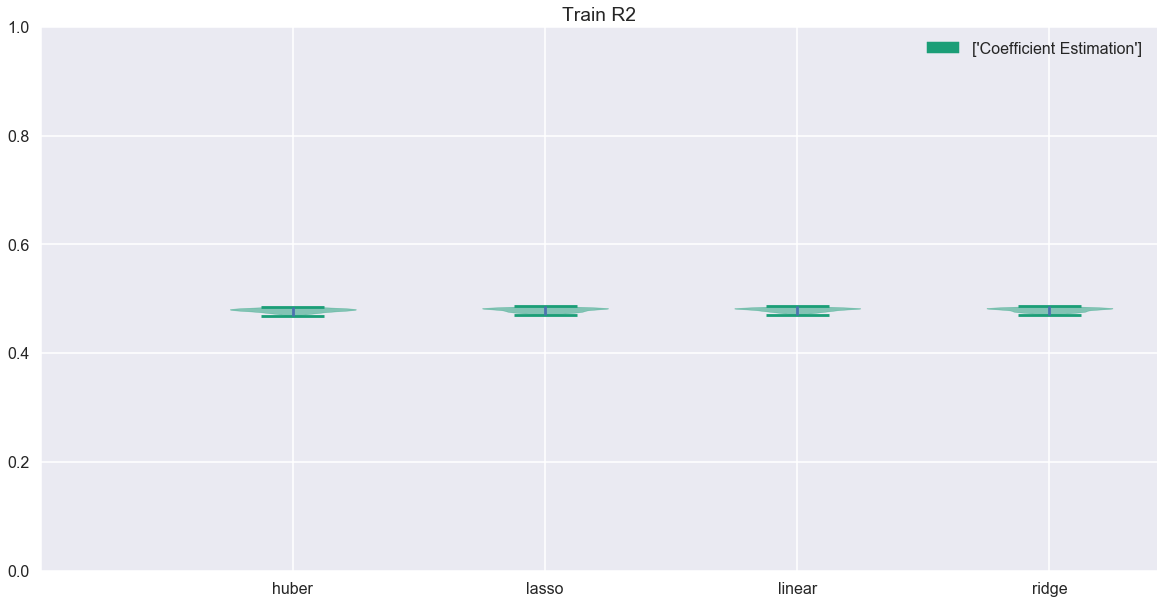

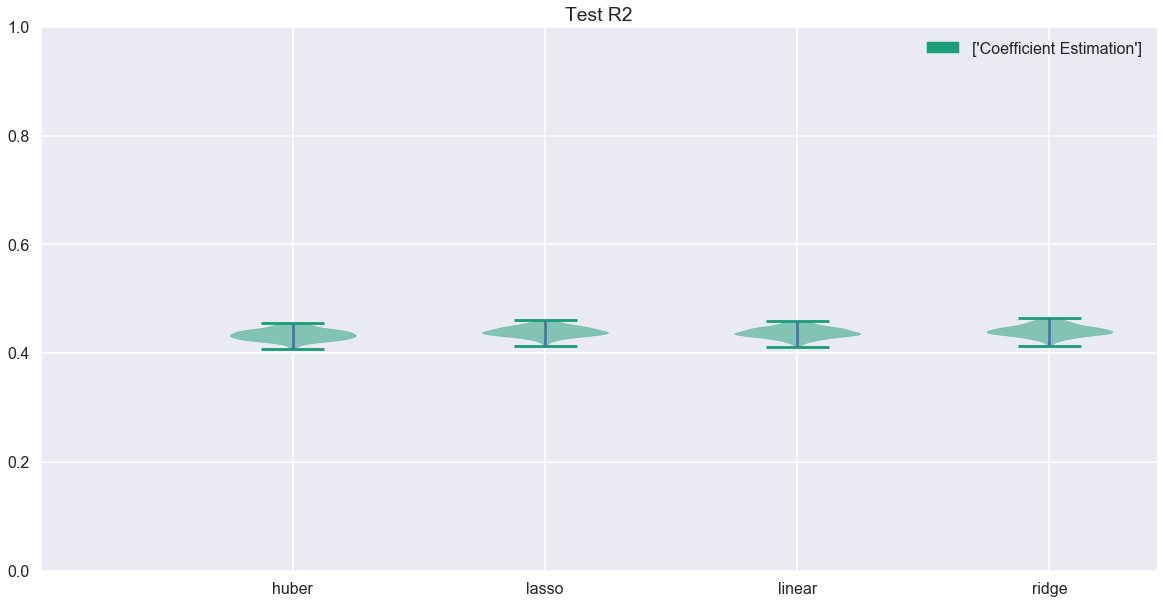

In [17]:
violin_plots(exp_1, ['Train R2','Test R2'], experiment_name=['Coefficient Estimation'], center_zero=False)

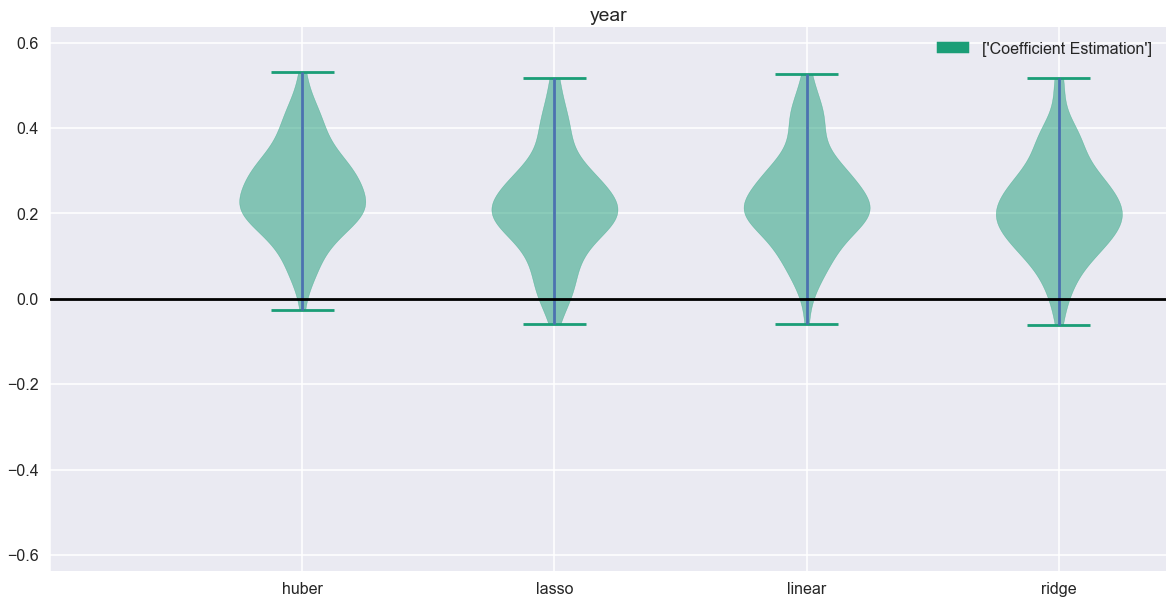

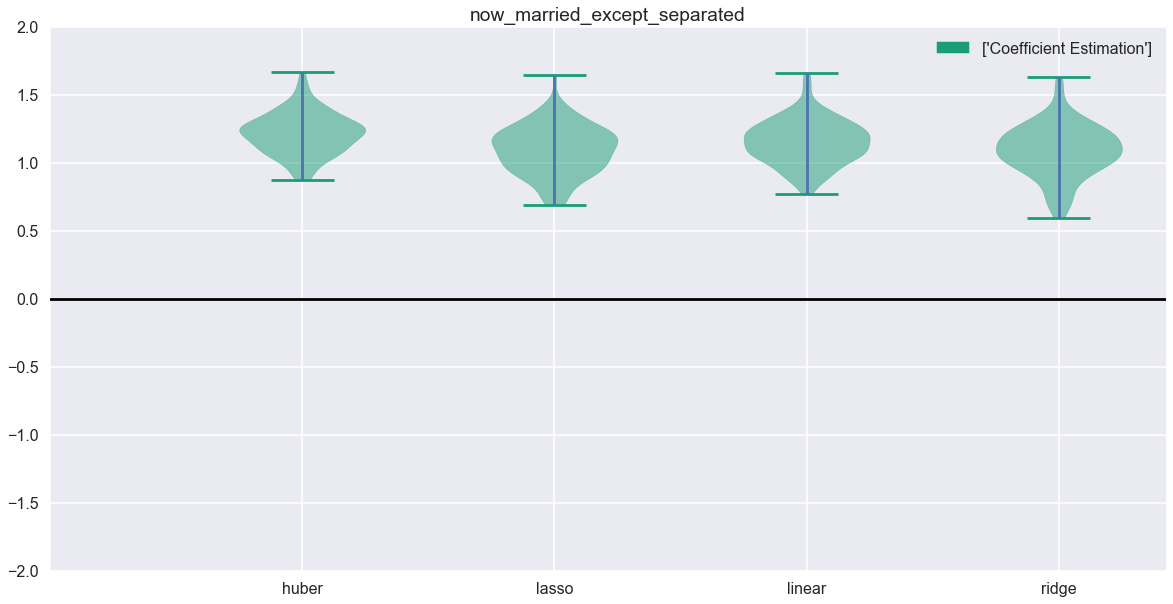

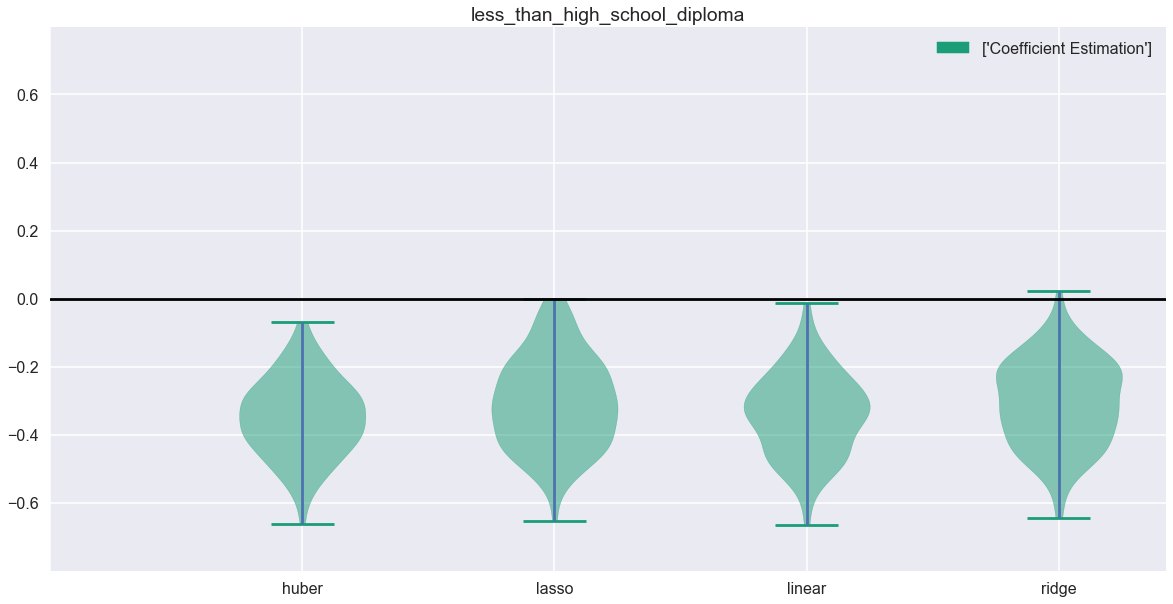

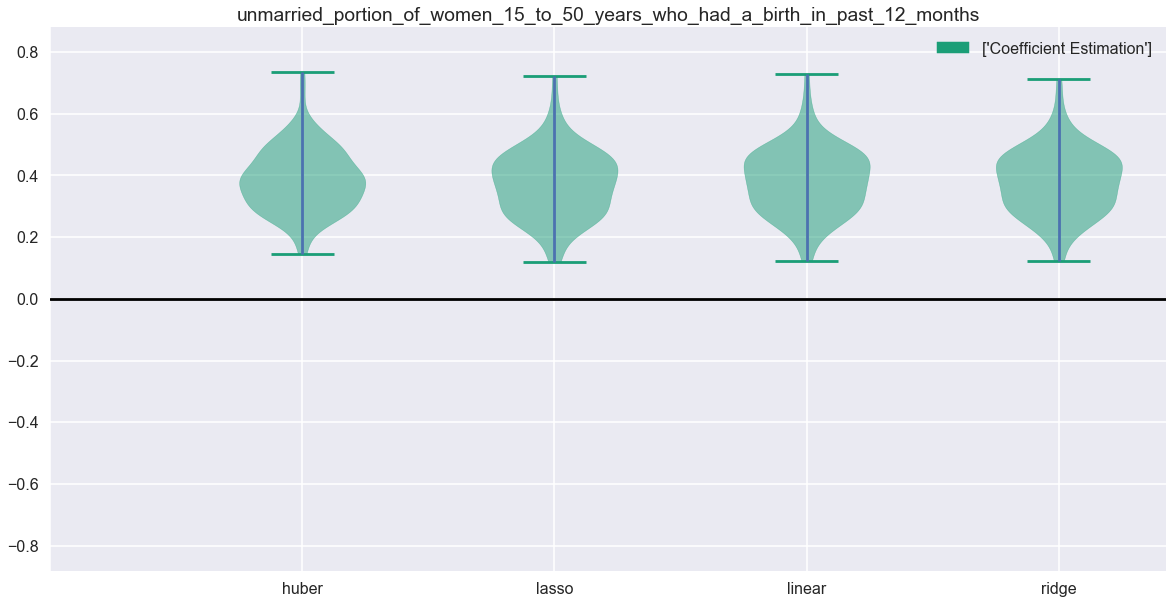

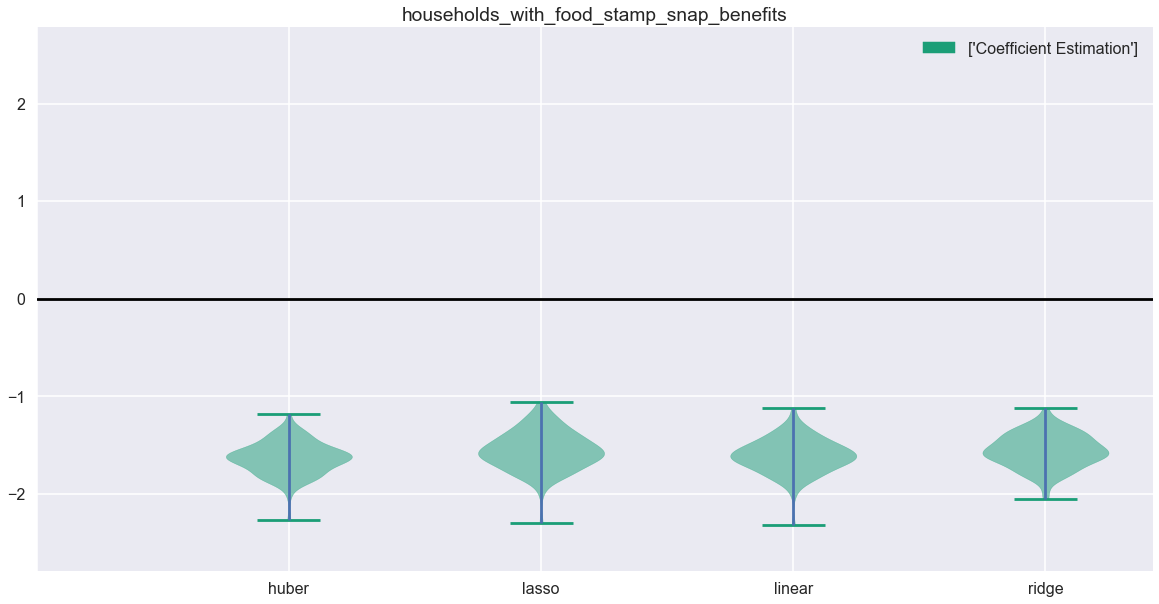

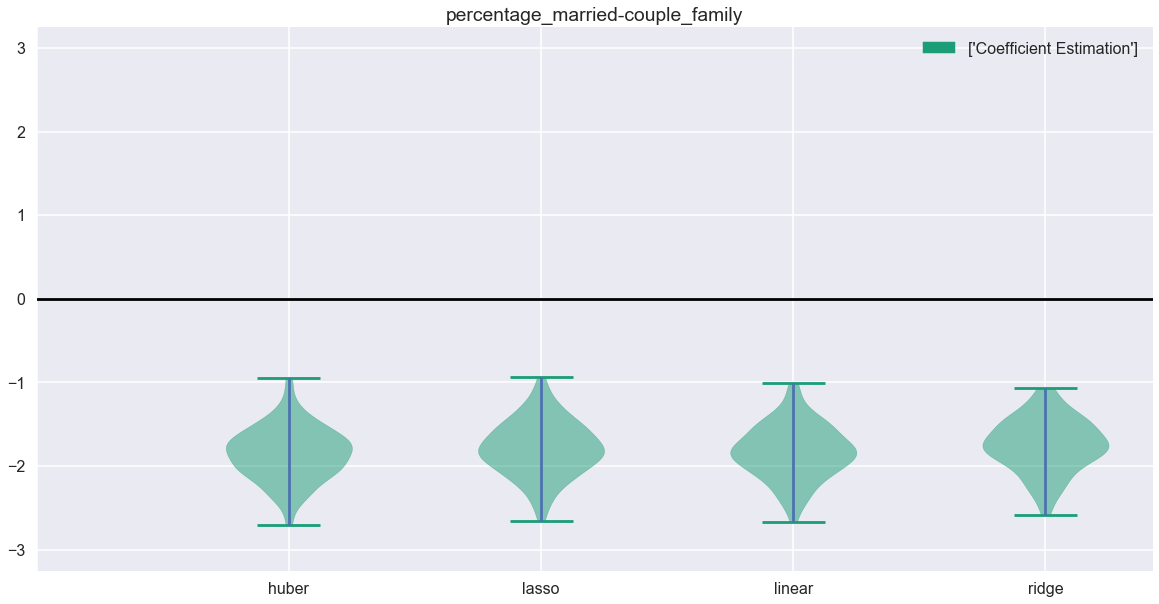

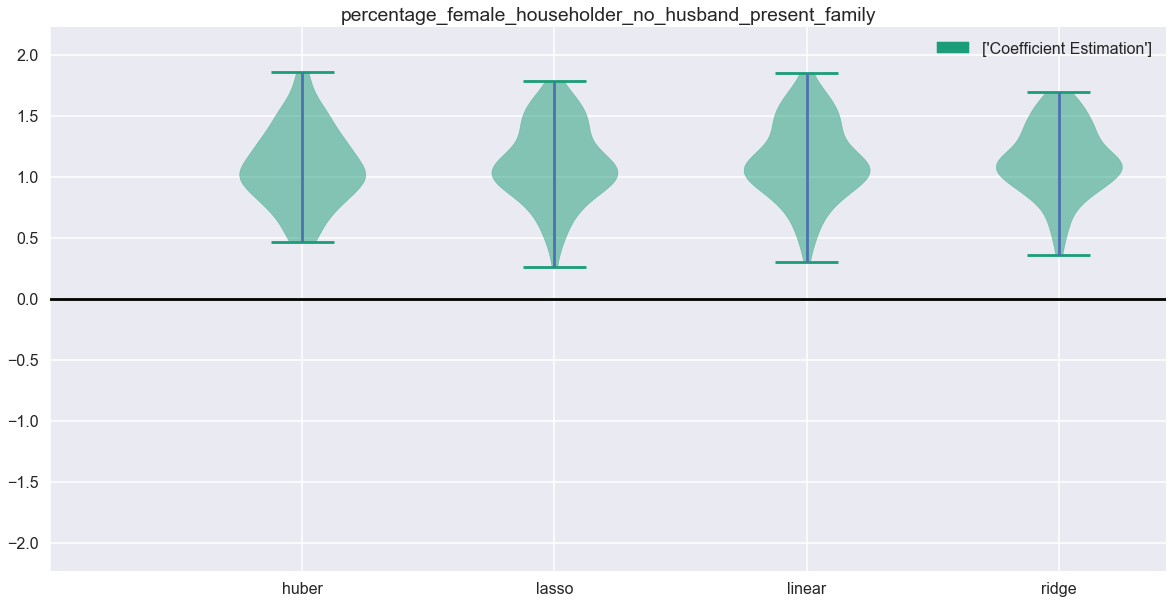

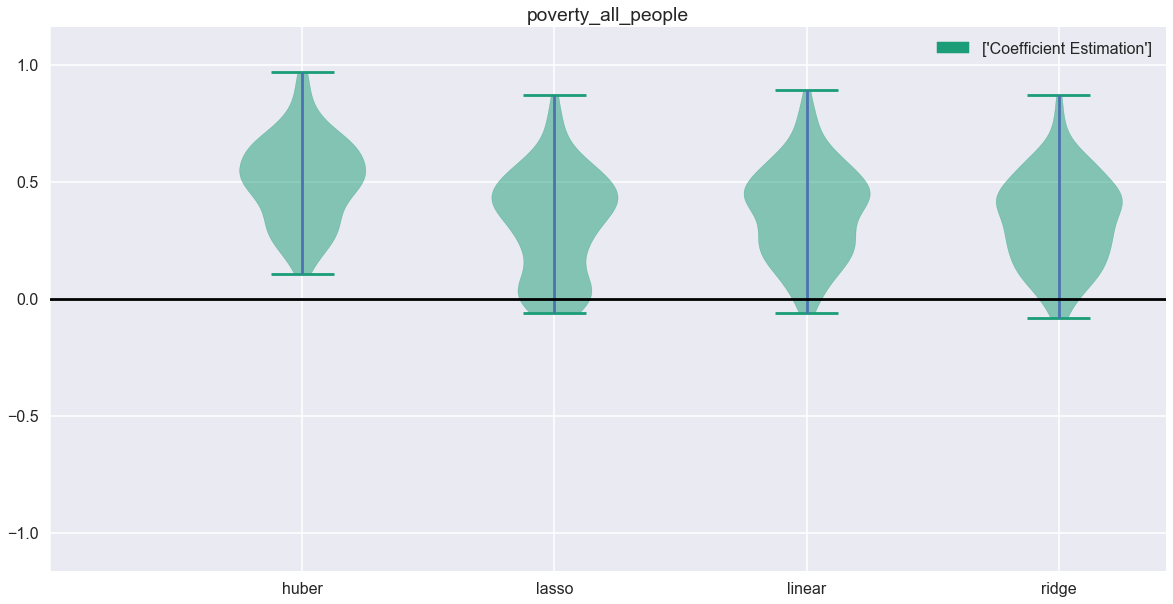

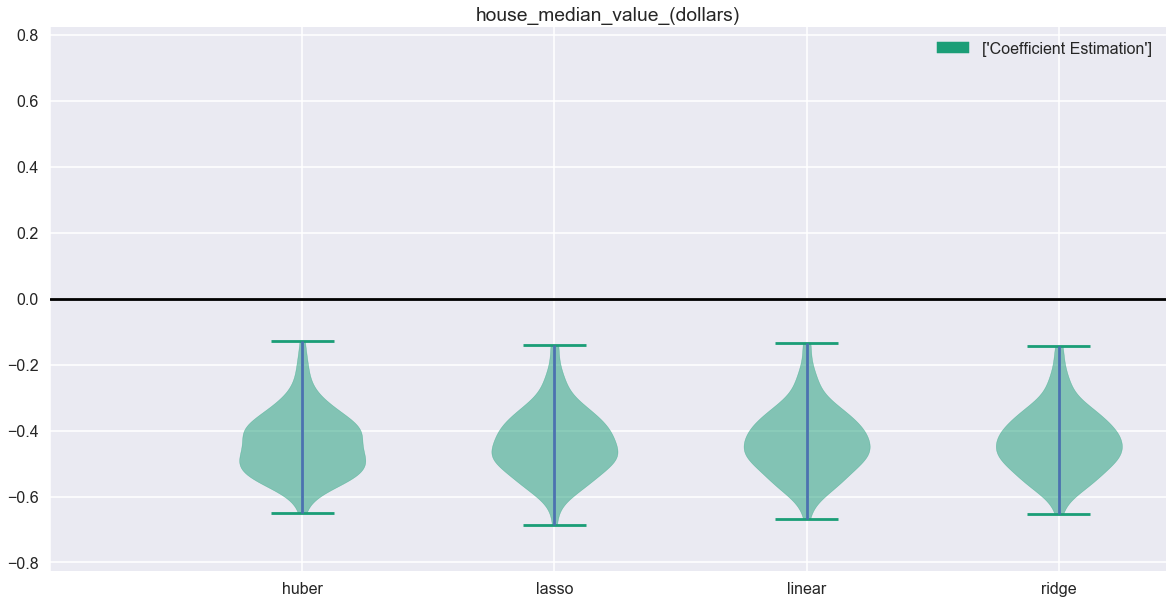

In [18]:
violin_plots(exp_1, x_train.columns, experiment_name=['Coefficient Estimation'])